### Outline:

Some EDA

Data Preprocessing: Column Transformer

Model Building: Pipeline

Model selection: Grid Search CV

Save model: Joblib

Make predictions on an unseen data point

In [1]:
pip install lightgbm


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib

In [3]:
df = pd.read_csv('StudentsPerformance.csv')
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [4]:
df.shape

(1000, 8)

In [5]:
df.isna().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

In [6]:
scores = df.columns[df.columns.str.contains('score')].tolist()
scores

['math score', 'reading score', 'writing score']

##### EDA:

histograms:

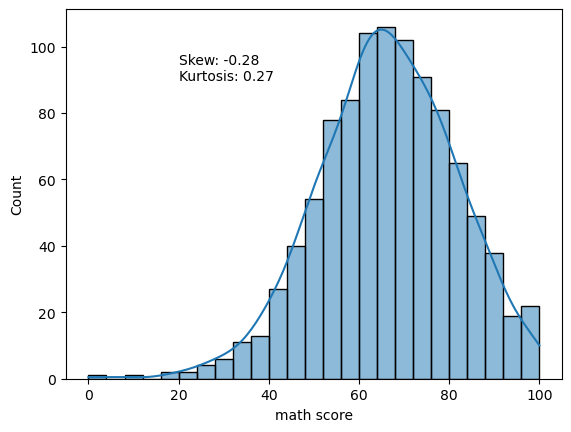

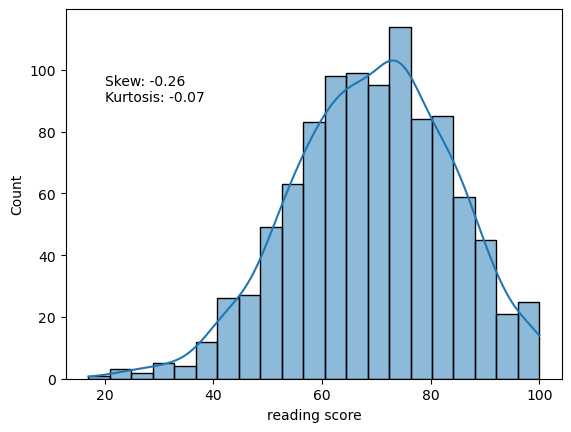

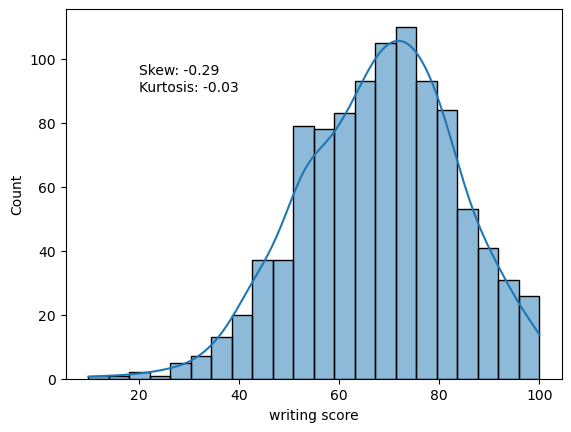

In [7]:
for score in scores:
    sns.histplot(df[score], element='bars', kde=True)
    plt.text(x=20, y=90, s=f"Skew: {round(df[score].skew(),2)}\nKurtosis: {round(df[score].kurt(),2)}")
    plt.show()

In [8]:
df.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


pairplot:

C:\Users\ADMIN\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


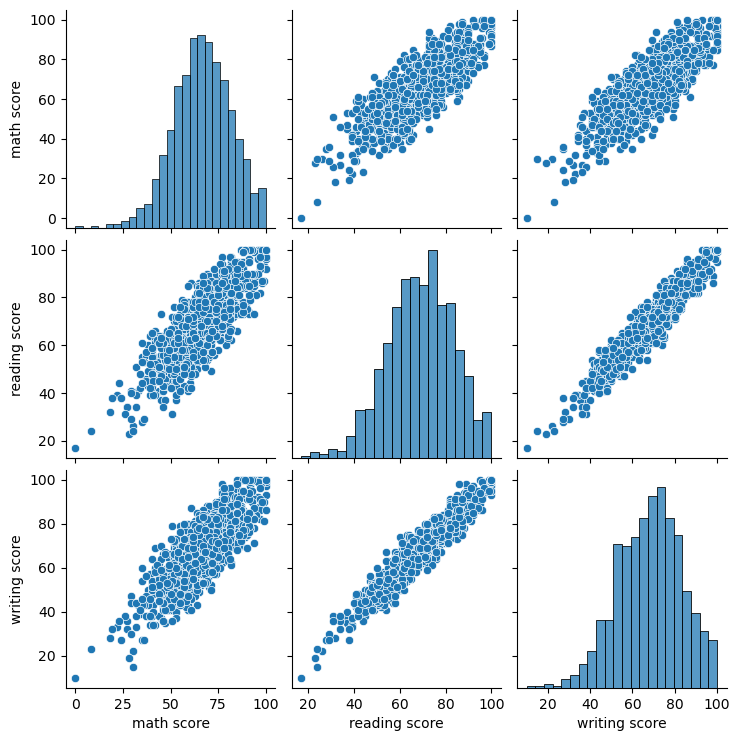

In [9]:
sns.pairplot(data=df)

scores vs lunch type:

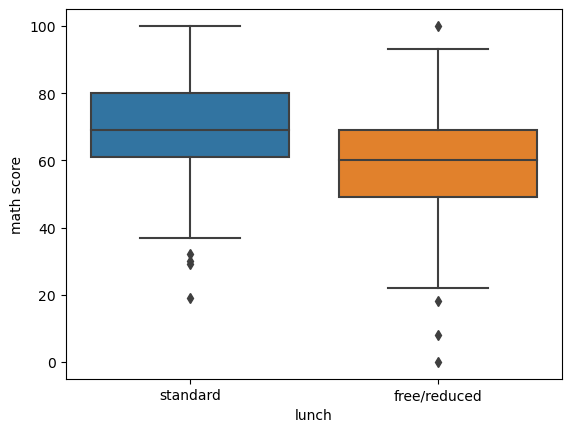

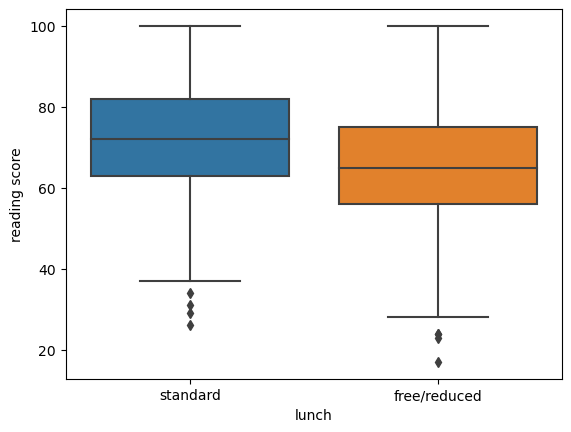

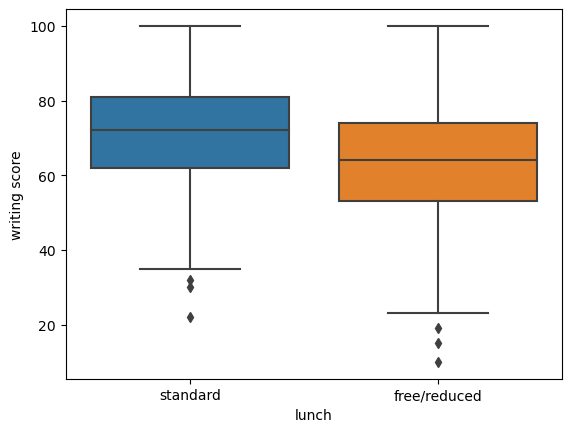

In [10]:
for score in scores:
    sns.boxplot(y=df[score], x=df['lunch'])
    plt.show()

scores vs race/ ethnicity group:

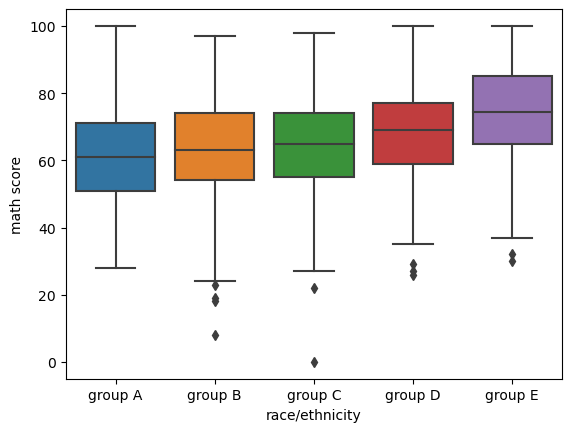

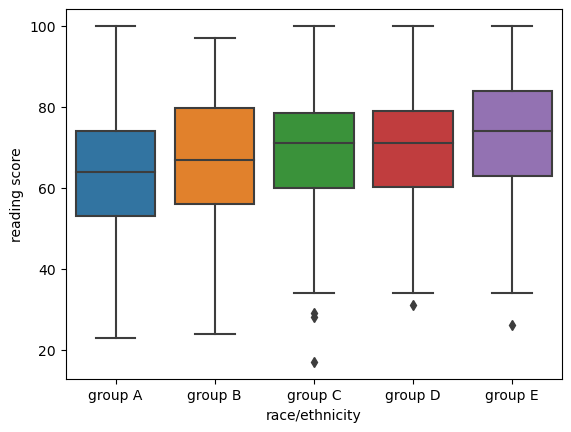

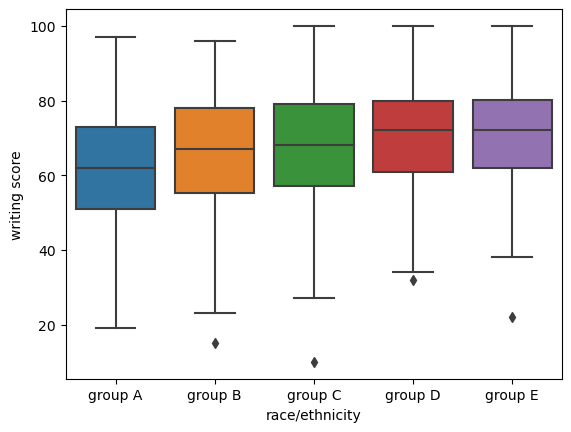

In [11]:
for score in scores:
    sns.boxplot(y=df[score], x=df['race/ethnicity'], order=sorted(df['race/ethnicity'].unique()))
    plt.show()

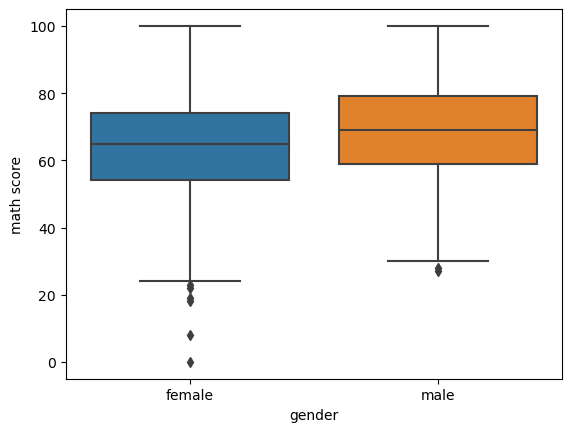

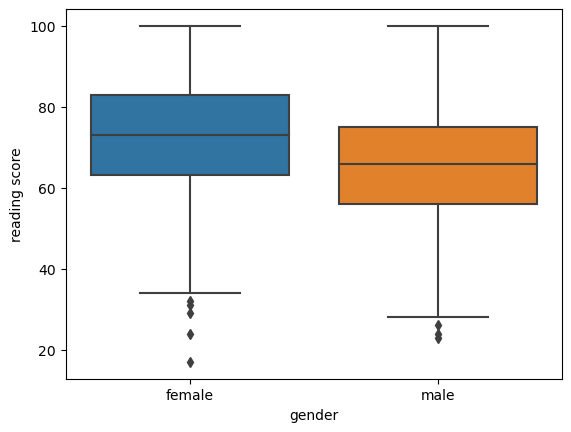

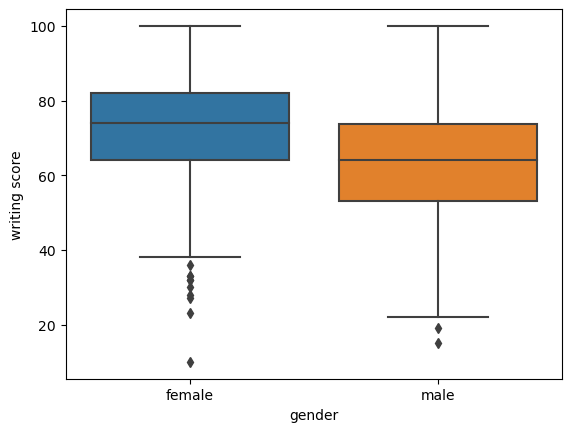

In [12]:
for score in scores:
    sns.boxplot(y=df[score], x=df['gender'])
    plt.show()

scores vs whether completed the test prep course:

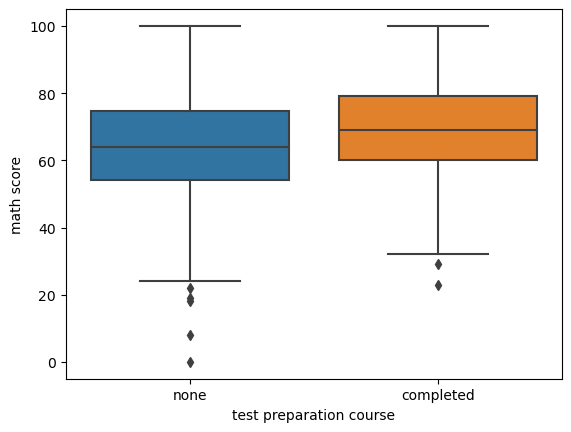

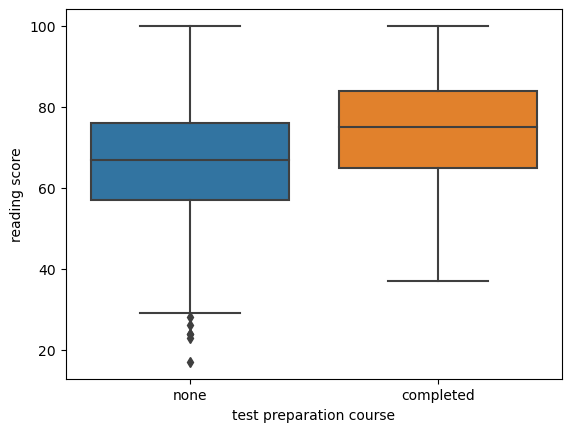

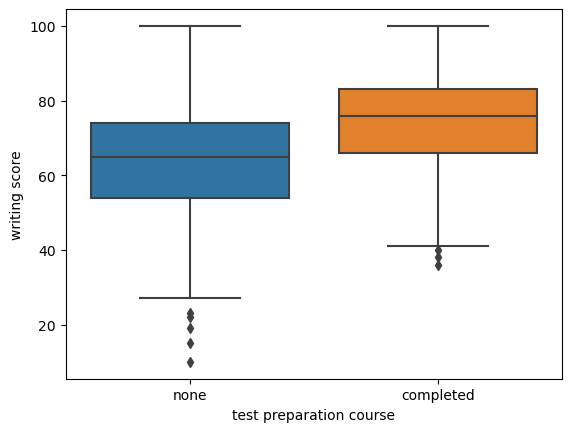

In [13]:
for score in scores:
    sns.boxplot(y=df[score], x=df['test preparation course'])
    plt.show()

scores vs parental education level:

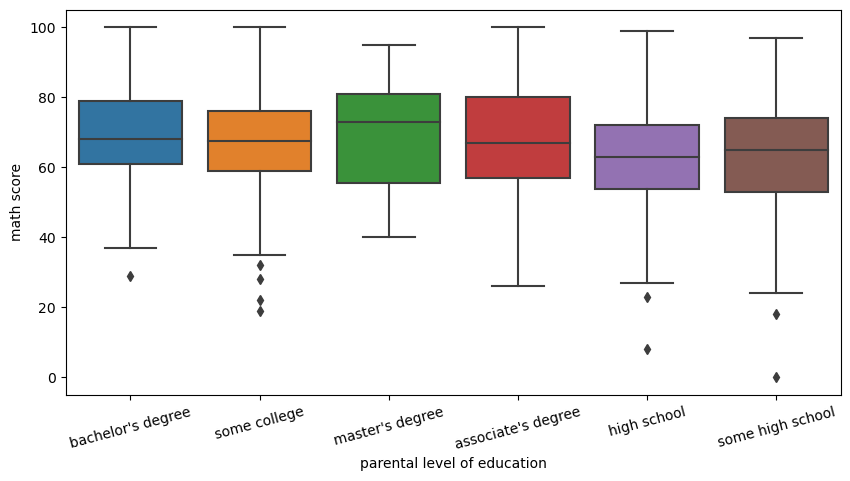

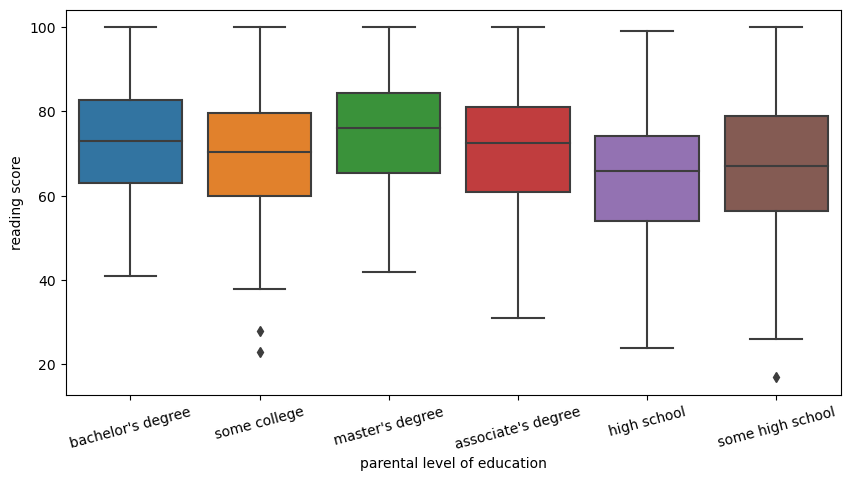

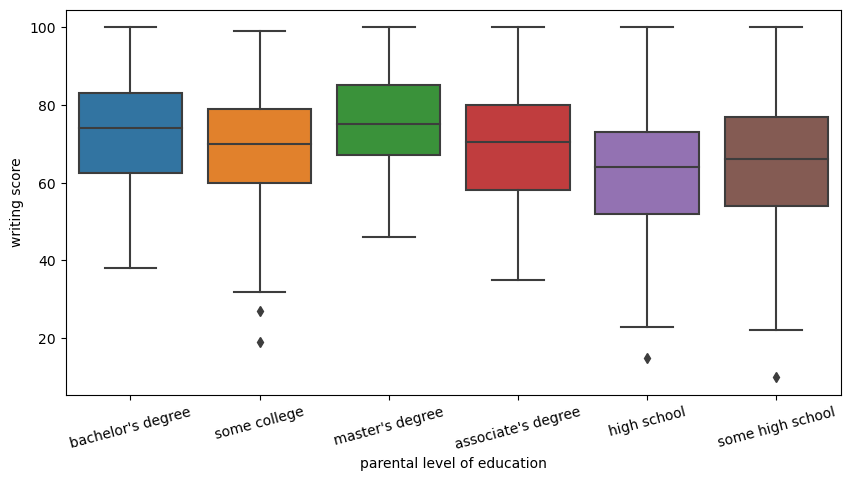

In [14]:
for score in scores:
    plt.figure(figsize=(10,5))
    sns.boxplot(y=df[score], x=df['parental level of education'])
    plt.xticks(rotation=15)
    plt.show()

In [15]:
X, y = df.drop('writing score', axis=1), df['writing score']

In [16]:
cat_cols = X.dtypes[X.dtypes == 'O'].index.tolist()
cat_cols

['gender',
 'race/ethnicity',
 'parental level of education',
 'lunch',
 'test preparation course']

In [17]:
ct = ColumnTransformer([
#     ('num', StandardScaler(), ['reading score', 'math score']),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_cols)
], remainder='passthrough')

In [18]:
ct.fit_transform(X).shape

C:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(1000, 19)

In [19]:
pipe = Pipeline([
    ('trf', ct),
    ('model', LGBMRegressor(random_state=0))
])

In [20]:
params = {
    'model__n_estimators':[100,130,150,170,190],
    'model__boosting_type': ['dart', 'gbdt', 'goss']
}

In [21]:
gs = GridSearchCV(pipe, param_grid=params, scoring='neg_root_mean_squared_error', n_jobs=-1)

In [22]:
gs.fit(X, y)

C:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 19
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 68.054000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

GridSearchCV(estimator=Pipeline(steps=[('trf',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['gender',
                                                                          'race/ethnicity',
                                                                          'parental '
                                                                          'level '
                                                                          'of '
                                                                          'education',
                                                                          'lunch',
                                                                          'test '
                                                                          'preparation '
                                                                          'course'])])),
                                       ('model',
                                        LGBMRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model__boosting_type': ['dart', 'gbdt', 'goss'],
                         'model__n_estimators': [100, 130, 150, 170, 190]},
             scoring='neg_root_mean_squared_error')

In [23]:
pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__boosting_type,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
12,0.222294,0.007118,0.009490,7.751289e-03,goss,150,"{'model__boosting_type': 'goss', 'model__n_est...",-4.396099,-3.819121,-3.742826,-3.443340,-3.992579,-3.878793,0.313758,1
13,0.234894,0.001466,0.015624,2.336015e-07,goss,170,"{'model__boosting_type': 'goss', 'model__n_est...",-4.423837,-3.848278,-3.713597,-3.472988,-3.989236,-3.889587,0.316729,2
14,0.257796,0.015842,0.015806,3.638277e-04,goss,190,"{'model__boosting_type': 'goss', 'model__n_est...",-4.394623,-3.845707,-3.687763,-3.499154,-4.025247,-3.890499,0.306123,3
11,0.197642,0.012758,0.012499,6.249595e-03,goss,130,"{'model__boosting_type': 'goss', 'model__n_est...",-4.419395,-3.833498,-3.796061,-3.472320,-3.994834,-3.903222,0.308820,4
10,0.156239,0.009881,0.009374,7.654149e-03,goss,100,"{'model__boosting_type': 'goss', 'model__n_est...",-4.380628,-3.921727,-3.776939,-3.504118,-4.005476,-3.917778,0.287363,5
5,0.297630,0.019438,0.011632,6.053664e-03,gbdt,100,"{'model__boosting_type': 'gbdt', 'model__n_est...",-4.394029,-3.919853,-3.790584,-3.823524,-4.038057,-3.993209,0.218128,6
6,0.344597,0.014954,0.015624,3.162980e-07,gbdt,130,"{'model__boosting_type': 'gbdt', 'model__n_est...",-4.425160,-3.945710,-3.813887,-3.904709,-4.083423,-4.034578,0.213733,7
7,0.389527,0.018389,0.012500,6.249905e-03,gbdt,150,"{'model__boosting_type': 'gbdt', 'model__n_est...",-4.446083,-3.938389,-3.830534,-3.920707,-4.117453,-4.050633,0.218526,8
8,0.432939,0.007342,0.015624,9.464947e-07,gbdt,170,"{'model__boosting_type': 'gbdt', 'model__n_est...",-4.469208,-3.949160,-3.860081,-3.933425,-4.150942,-4.072563,0.220548,9
9,0.495924,0.035080,0.012499,6.249571e-03,gbdt,190,"{'model__boosting_type': 'gbdt', 'model__n_est...",-4.520730,-3.977621,-3.891544,-3.949715,-4.160099,-4.099942,0.228754,10


In [24]:
gs.best_params_

{'model__boosting_type': 'goss', 'model__n_estimators': 150}

In [25]:
gs.best_score_

-3.8787930106549338

In [26]:
gs.best_estimator_

Pipeline(steps=[('trf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['gender', 'race/ethnicity',
                                                   'parental level of '
                                                   'education',
                                                   'lunch',
                                                   'test preparation '
                                                   'course'])])),
                ('model',
                 LGBMRegressor(boosting_type='goss', n_estimators=150,
                               random_state=0))])

In [27]:
joblib.dump(gs.best_estimator_, 'model.joblib')

['model.joblib']

##### importing the model:

In [28]:
mdl = joblib.load('model.joblib')

##### Making predictions on a new data point NOT seen by the model

In [31]:
q = pd.DataFrame([['female', 'group A', 'high school', 'standard', 'completed', 10,67]],
             columns=X.columns)
q

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score
0,female,group A,high school,standard,completed,10,67


In [30]:
mdl.predict(q)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


array([53.04916104])